# Spiking multicompartment PC network

## Abstract
Predictive coding is a promising theoretical framework for understanding the hierarchical sensory processing in the brain, yet how it is implemented with cortical spiking neurons is still unclear. While most existing works have taken a hand-wiring approach to creating microcircuits which match experimental results, recent work in applying the optimisation approach revealed that cortical connectivity might result from self-organisation given some fundamental computational principle, ie. energy efficiency. We thus investigated whether predictive coding properties in a multicompartment spiking neural network can result from energy optimisation. We found that only the model trained with an energy objective in addition to a task-relevant objective was able to reconstruct internal representations given top-down expectation signals alone. Neurons in the energy-optimised model also showed differential responses to expected vs unexpected stimuli, qualitatively similar to experimental evidence for predictive coding. These findings indicated that predictive-coding-like behaviour might be an emergent property of energy optimisation, providing a new perspective on how predictive coding could be achieved in the cortex.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.nn.parameter import Parameter
from torch.nn import init
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision
import numpy as np
from datetime import date
import os
import pandas as pd
import math
import shutil


import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# set seed
torch.manual_seed(999)


cpu


In [5]:
## Utils
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def save_checkpoint(state, is_best, prefix, filename='_rec2_bias_checkpoint.pth.tar'):
    print('saving at ', prefix + filename)
    torch.save(state, prefix + filename)
    if is_best:
        shutil.copyfile(prefix + filename, prefix + '_rec2_bias_model_best.pth.tar')


def model_result_dict_load(fn):
    """load tar file with saved model

    Args:
        fn (str): tar file name

    Returns:
        dict: dictornary containing saved results
    """
    with open(fn, 'rb') as f:
        dict = torch.load(f)
    return dict



## Import dataset

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 200

traindata = torchvision.datasets.MNIST(root='./data', train=True,
                                       download=True, transform=transform)

testdata = torchvision.datasets.MNIST(root='./data', train=False,
                                      download=True, transform=transform)

# data loading
train_loader = torch.utils.data.DataLoader(traindata, batch_size=batch_size,
                                           shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                          shuffle=False, num_workers=2)


100%|██████████| 9912422/9912422 [00:00<00:00, 21552506.21it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 15492657.67it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4549923.28it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



## Surrogate gradient


In [7]:

b_j0 = 0.1  # neural threshold baseline

R_m = 3  # membrane resistance
gamma = .5  # gradient scale
lens = 0.5


def gaussian(x, mu=0., sigma=.5):
    return torch.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / torch.sqrt(2 * torch.tensor(math.pi)) / sigma


class ActFun_adp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):  # input = membrane potential- threshold
        ctx.save_for_backward(input)
        return input.gt(0).float()  # is firing ???

    @staticmethod
    def backward(ctx, grad_output):  # approximate the gradients
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # temp = abs(input) < lens
        scale = 6.0
        hight = .15
        # temp = torch.exp(-(input**2)/(2*lens**2))/torch.sqrt(2*torch.tensor(math.pi))/lens
        temp = gaussian(input, mu=0., sigma=lens) * (1. + hight) \
               - gaussian(input, mu=lens, sigma=scale * lens) * hight \
               - gaussian(input, mu=-lens, sigma=scale * lens) * hight
        # temp =  gaussian(input, mu=0., sigma=lens)
        return grad_input * temp.float() * gamma
        # return grad_input


act_fun_adp = ActFun_adp.apply

## Network layers

In [8]:
# layers
def shifted_sigmoid(currents):
    return (1 / (1 + torch.exp(-currents)) - 0.5)/2


class SnnLayer(nn.Module):
    def __init__(
            self,
            in_dim: int,
            hidden_dim: int,
            is_rec: bool,
            is_adapt: bool,
            one_to_one: bool,
            tau_m_init=15.,
            tau_adap_init=20,
            tau_a_init=15.,
            dt = 0.5,
            bias = True
    ):
        super(SnnLayer, self).__init__()

        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.is_rec = is_rec
        self.is_adapt = is_adapt
        self.one_to_one = one_to_one
        self.dt = dt

        if is_rec:
            self.rec_w = nn.Linear(hidden_dim, hidden_dim, bias=bias)
            # init weights
            if bias:
                nn.init.constant_(self.rec_w.bias, 0)
            nn.init.xavier_uniform_(self.rec_w.weight)

            p = torch.full(self.rec_w.weight.size(), fill_value=0.5).to(device)
            self.weight_mask = torch.bernoulli(p)

        else:
            self.fc_weights = nn.Linear(in_dim, hidden_dim, bias=bias)
            if bias:
                nn.init.constant_(self.fc_weights.bias, 0)
            nn.init.xavier_uniform_(self.fc_weights.weight)

        # define param for time constants
        self.tau_adp = nn.Parameter(torch.Tensor(hidden_dim))
        self.tau_m = nn.Parameter(torch.Tensor(hidden_dim))
        self.tau_a = nn.Parameter(torch.Tensor(hidden_dim))

        nn.init.normal_(self.tau_adp, tau_adap_init, .1)
        nn.init.normal_(self.tau_m, tau_m_init, .1)
        nn.init.normal_(self.tau_a, tau_a_init, 0.1)

        # self.tau_adp = nn.Parameter(torch.Tensor(1))
        # self.tau_m = nn.Parameter(torch.Tensor(1))
        # self.tau_a = nn.Parameter(torch.Tensor(1))

        # nn.init.constant_(self.tau_adp, tau_adap_init)
        # nn.init.constant_(self.tau_m, tau_m_init)
        # nn.init.constant_(self.tau_a, tau_a_init)

        # nn.init.normal_(self.tau_adp, 200., 20.)
        # nn.init.normal_(self.tau_m, 20., .5)

        self.sigmoid = nn.Sigmoid()

    def mem_update(self, ff, fb, soma, spike, a_curr, b, is_adapt, baseline_thre=b_j0, r_m=3):
        """
        mem update for each layer of neurons
        :param ff: feedforward signal
        :param fb: feedback signal to apical tuft
        :param soma: mem voltage potential at soma
        :param spike: spiking at last time step
        :param a_curr: apical tuft current at last t
        :param b: adaptive threshold
        :return:
        """
        # alpha = self.sigmoid(self.tau_m)
        # rho = self.sigmoid(self.tau_adp)
        # eta = self.sigmoid(self.tau_a)
        alpha = torch.exp(-self.dt/self.tau_m)
        rho = torch.exp(-self.dt/self.tau_adp)
        eta = torch.exp(-self.dt/self.tau_a)

        if is_adapt:
            beta = 1.8
        else:
            beta = 0.

        b = rho * b + (1 - rho) * spike  # adaptive contribution
        new_thre = baseline_thre + beta * b  # udpated threshold

        a_new = eta * a_curr + fb  # fb into apical tuft

        soma_new = alpha * soma + shifted_sigmoid(a_new) + ff - new_thre * spike
        # soma_new = alpha * soma + 1/2 * (a_new) + ffs - new_thre * spike

        inputs_ = soma_new - new_thre

        spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
        # mem = (1 - spike) * mem

        return soma_new, spike, a_new, new_thre, b

    def forward(self, ff, fb, soma_t, spk_t, a_curr_t, b_t):
        """
        forward function of a single layer. given previous neuron states and current input, update neuron states

        :param ff: ff signal (not counting rec)
        :param fb: fb top down signal
        :param soma_t: soma voltage
        :param a_curr_t: apical tuft voltage
        :return:
        """

        if self.is_rec:
            self.rec_w.weight.data = self.rec_w.weight.data * self.weight_mask
            # self.rec_w.weight.data = (self.rec_w.weight.data < 0).float() * self.rec_w.weight.data
            r_in = ff + self.rec_w(spk_t)
        else:
            if self.one_to_one:
                r_in = ff
            else:
                r_in = self.fc_weights(ff)

        soma_t1, spk_t1, a_curr_t1, _, b_t1 = self.mem_update(r_in, fb, soma_t, spk_t, a_curr_t, b_t, self.is_adapt)

        return soma_t1, spk_t1, a_curr_t1, b_t1


class OutputLayer(nn.Module):
    def __init__(
            self,
            in_dim: int,
            out_dim: int,
            is_fc: bool,
            tau_fixed=None,
            bias = True,
            dt=0.5
    ):
        """
        output layer class
        :param is_fc: whether integrator is fc to r_out in rec or not
        """
        super(OutputLayer, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.is_fc = is_fc
        self.dt = dt

        if is_fc:
            self.fc = nn.Linear(in_dim, out_dim, bias=bias)
            if bias:
                nn.init.constant_(self.fc.bias, 0)
            nn.init.xavier_uniform_(self.fc.weight)

        # tau_m
        if tau_fixed is None:
            self.tau_m = nn.Parameter(torch.Tensor(out_dim))
            nn.init.constant_(self.tau_m, 5)
        else:
            self.tau_m = nn.Parameter(torch.Tensor(out_dim), requires_grad=False)
            nn.init.constant_(self.tau_m, tau_fixed)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x_t, mem_t):
        """
        integrator neuron without spikes
        """
        alpha = torch.exp(-self.dt/self.tau_m)
        # alpha = self.sigmoid(self.tau_m)

        if self.is_fc:
            x_t = self.fc(x_t)
        else:
            x_t = x_t.view(-1, 10, int(self.in_dim / 10)).mean(dim=2)  # sum up population spike

        # d_mem = -soma_t + x_t
        mem = (mem_t + x_t) * alpha
        # mem = alpha * soma_t + (1 - alpha) * x_t
        return mem



In [1]:
self.tau_m

NameError: name 'self' is not defined

## Network class

In [9]:
# 2 hidden layers
class SnnNetwork(nn.Module):
    def __init__(
            self,
            in_dim: int,
            hidden_dims: list,
            out_dim: int,
            is_adapt: bool,
            one_to_one: bool,
            dp_rate: float,
            is_rec: bool,
            bias = True
    ):
        super(SnnNetwork, self).__init__()

        self.in_dim = in_dim
        self.hidden_dims = hidden_dims
        self.out_dim = out_dim
        self.is_adapt = is_adapt
        self.one_to_one = one_to_one
        self.is_rec = is_rec

        self.dp = nn.Dropout(dp_rate)

        self.layer1 = SnnLayer(hidden_dims[0], hidden_dims[0], is_rec=is_rec, is_adapt=is_adapt,
                               one_to_one=one_to_one, bias=bias)

        # r in to r out
        self.layer1to2 = nn.Linear(hidden_dims[0], hidden_dims[1], bias=bias)
        nn.init.xavier_uniform_(self.layer1to2.weight)

        # r out to r in
        self.layer2to1 = nn.Linear(hidden_dims[1], hidden_dims[0], bias=bias)
        nn.init.xavier_uniform_(self.layer2to1.weight)

        self.layer2 = SnnLayer(hidden_dims[1], hidden_dims[1], is_rec=is_rec, is_adapt=is_adapt,
                               one_to_one=one_to_one, bias=bias)

        self.output_layer = OutputLayer(hidden_dims[1], out_dim, is_fc=True, bias=bias)

        self.out2layer2 = nn.Linear(out_dim, hidden_dims[1], bias=bias)
        nn.init.xavier_uniform_(self.out2layer2.weight)

        if bias:
            nn.init.constant_(self.layer1to2.bias, 0)
            nn.init.constant_(self.layer2to1.bias, 0)
            nn.init.constant_(self.out2layer2.bias, 0)



        self.fr_layer2 = 0
        self.fr_layer1 = 0

        self.error1 = 0
        self.error2 = 0

    def forward(self, x_t, h):
        batch_dim, input_size = x_t.shape

        x_t = x_t.reshape(batch_dim, input_size).float()
        x_t = self.dp(x_t*0.5)
        # poisson
        # x_t = x_t.gt(0.7).float()

        soma_1, spk_1, a_curr_1, b_1 = self.layer1(ff=x_t, fb=self.layer2to1(h[5]), soma_t=h[0], spk_t=h[1],
                                                   a_curr_t=h[2], b_t=h[3])

        self.error1 = a_curr_1 - soma_1

        # use out mem signal as feedback
        soma_2, spk_2, a_curr_2, b_2 = self.layer2(ff=self.layer1to2(spk_1), fb=self.out2layer2(F.normalize(h[-1], dim=1)), soma_t=h[4],
                                                   spk_t=h[5], a_curr_t=h[6], b_t=h[7])

        self.error2 = a_curr_2 - soma_2

        self.fr_layer2 = self.fr_layer2 + spk_2.detach().cpu().numpy().mean()
        self.fr_layer1 = self.fr_layer1 + spk_1.detach().cpu().numpy().mean()

        # read out from r_out neurons
        mem_out = self.output_layer(spk_2, h[-1])

        h = (soma_1, spk_1, a_curr_1, b_1,
             soma_2, spk_2, a_curr_2, b_2,
             mem_out)

        log_softmax = F.log_softmax(mem_out, dim=1)

        return log_softmax, h

    def inference(self, x_t, h, T, bystep=None):
        """
        only called during inference
        :param x_t: input
        :param h: hidden states
        :param T: sequence length
        :param bystep: if true, then x_t is a sequence
        :return:
        """

        log_softmax_hist = []
        h_hist = []

        for t in range(T):
            if bystep is None:
                log_softmax, h = self.forward(x_t, h)
            else:
                log_softmax, h = self.forward(x_t[t], h)


            log_softmax_hist.append(log_softmax)
            h_hist.append(h)

        return log_softmax_hist, h_hist

    def clamped_generate(self, test_class, zeros, h_clamped, T, clamp_value=0.5, batch=False, noise=None):
        """
        generate representations with mem of read out clamped
        :param test_class: which class is clamped
        :param zeros: input containing zeros, absence of input
        :param h: hidden states
        :param T: sequence length
        :return:
        """

        log_softmax_hist = []
        h_hist = []

        for t in range(T):
            if not batch:
                h_clamped[-1][0] = -clamp_value
                h_clamped[-1][0, test_class] = clamp_value
            else:
                h_clamped[-1][:, :] = torch.full(h_clamped[-1].size(), -clamp_value).to(device)
                h_clamped[-1][:, test_class] = clamp_value

            if noise is not None:
                    h_clamped[-1][:] += noise

            # if t==0:
            #     print(h_clamped[-1])

            log_softmax, h_clamped = self.forward(zeros, h_clamped)

            log_softmax_hist.append(log_softmax)
            h_hist.append(h_clamped)

        return log_softmax_hist, h_hist

    def init_hidden(self, bsz):
        weight = next(self.parameters()).data
        return (
            # r
            weight.new(bsz, self.hidden_dims[0]).uniform_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).fill_(b_j0),
            # p
            weight.new(bsz, self.hidden_dims[1]).uniform_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).fill_(b_j0),
            # layer out
            weight.new(bsz, self.out_dim).zero_(),
            # sum spike
            weight.new(bsz, self.out_dim).zero_(),
        )


# 3 hidden layers

class SnnNetwork3Layer(SnnNetwork):
    def __init__(
            self,
            in_dim: int,
            hidden_dims: list,
            out_dim: int,
            is_adapt: bool,
            one_to_one: bool,
            dp_rate: float,
            is_rec: bool,
            bias = True
    ):
        super().__init__(in_dim, hidden_dims, out_dim, is_adapt, one_to_one, dp_rate, is_rec)

        self.layer3 = SnnLayer(hidden_dims[2], hidden_dims[2], is_rec=is_rec, is_adapt=is_adapt,
                               one_to_one=one_to_one, bias=bias)

        self.layer2to3 = nn.Linear(hidden_dims[1], hidden_dims[2], bias=bias)
        nn.init.xavier_uniform_(self.layer2to3.weight)

        # r out to r in
        self.layer3to2 = nn.Linear(hidden_dims[2], hidden_dims[1], bias=bias)
        nn.init.xavier_uniform_(self.layer3to2.weight)

        self.output_layer = OutputLayer(hidden_dims[2], out_dim, is_fc=True)

        self.out2layer3 = nn.Linear(out_dim, hidden_dims[2], bias=bias)
        nn.init.xavier_uniform_(self.out2layer3.weight)

        self.fr_layer3 = 0

        self.error3 = 0

        self.input_fc = nn.Linear(in_dim, hidden_dims[0], bias=bias)
        nn.init.xavier_uniform_(self.input_fc.weight)

        if bias:
            nn.init.constant_(self.layer2to3.bias, 0)
            nn.init.constant_(self.layer3to2.bias, 0)
            nn.init.constant_(self.out2layer3.bias, 0)
            nn.init.constant_(self.input_fc.bias, 0)
            print('bias set to 0')

    def forward(self, x_t, h):
        batch_dim, input_size = x_t.shape

        x_t = x_t.reshape(batch_dim, input_size).float()
        x_t = self.dp(x_t)
        # poisson
        # x_t = x_t.gt(0.7).float()
        x_t = self.input_fc(x_t)

        soma_1, spk_1, a_curr_1, b_1 = self.layer1(ff=x_t, fb=self.layer2to1(h[5]), soma_t=h[0], spk_t=h[1],
                                                   a_curr_t=h[2], b_t=h[3])

        self.error1 = a_curr_1 - soma_1

        # use out mem signal as feedback
        soma_2, spk_2, a_curr_2, b_2 = self.layer2(ff=self.layer1to2(spk_1), fb=self.layer3to2(h[9]), soma_t=h[4],
                                                   spk_t=h[5], a_curr_t=h[6], b_t=h[7])

        self.error2 = a_curr_2 - soma_2

        soma_3, spk_3, a_curr_3, b_3 = self.layer3(ff=self.layer2to3(spk_2), fb=self.out2layer3(F.normalize(h[-1], dim=1)), soma_t=h[8],
                                                   spk_t=h[9], a_curr_t=h[10], b_t=h[11])
        # soma_3, spk_3, a_curr_3, b_3 = self.layer3(ff=self.layer2to3(spk_2), fb=0, soma_t=h[8],
        #                                            spk_t=h[9], a_curr_t=h[10], b_t=h[11])

        self.error3 = a_curr_3 - soma_3

        self.fr_layer3 = self.fr_layer3 + spk_3.detach().cpu().numpy().mean()
        self.fr_layer2 = self.fr_layer2 + spk_2.detach().cpu().numpy().mean()
        self.fr_layer1 = self.fr_layer1 + spk_1.detach().cpu().numpy().mean()

        # read out from r_out neurons
        mem_out = self.output_layer(spk_3, h[-1])

        h = (soma_1, spk_1, a_curr_1, b_1,
             soma_2, spk_2, a_curr_2, b_2,
             soma_3, spk_3, a_curr_3, b_3,
             mem_out)

        log_softmax = F.log_softmax(mem_out, dim=1)

        return log_softmax, h


    def init_hidden(self, bsz):
        weight = next(self.parameters()).data
        return (
            # l1
            weight.new(bsz, self.hidden_dims[0]).uniform_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).fill_(b_j0),
            # l2
            weight.new(bsz, self.hidden_dims[1]).uniform_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).fill_(b_j0),
            # l3
            weight.new(bsz, self.hidden_dims[2]).uniform_(),
            weight.new(bsz, self.hidden_dims[2]).zero_(),
            weight.new(bsz, self.hidden_dims[2]).zero_(),
            weight.new(bsz, self.hidden_dims[2]).fill_(b_j0),
            # layer out
            weight.new(bsz, self.out_dim).zero_(),
            # sum spike
            weight.new(bsz, self.out_dim).zero_(),
        )

    def init_hidden_allzero(self, bsz):
        weight = next(self.parameters()).data
        return (
            # l1
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).fill_(b_j0),
            # l2
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).fill_(b_j0),
            # l3
            weight.new(bsz, self.hidden_dims[2]).zero_(),
            weight.new(bsz, self.hidden_dims[2]).zero_(),
            weight.new(bsz, self.hidden_dims[2]).zero_(),
            weight.new(bsz, self.hidden_dims[2]).fill_(b_j0),
            # layer out
            weight.new(bsz, self.out_dim).zero_(),
            # sum spike
            weight.new(bsz, self.out_dim).zero_(),
        )

    def clamp_withnoise(self, test_class, zeros, h_clamped, T, noise, index, batch=False, clamp_value=0.5):
        """
        generate representations with mem of read out clamped
        :param test_class: which class is clamped
        :param zeros: input containing zeros, absence of input
        :param h: hidden states
        :param T: sequence length
        :param noise: noise values
        :param index: index in h where noise is added to
        :return:
        """

        log_softmax_hist = []
        h_hist = []

        for t in range(T):
            if not batch:
                h_clamped[-1][0] = -clamp_value
                h_clamped[-1][0, test_class] = clamp_value
            else:
                h_clamped[-1][:, :] = torch.full(h_clamped[-1].size(), -clamp_value).to(device)
                h_clamped[-1][:, test_class] = clamp_value

            if noise is not None:
                h_clamped[index][:, :] += noise * h_clamped[index][:, :]

            # if t==0:
            #     print(h_clamped[-1])

            log_softmax, h_clamped = self.forward(zeros, h_clamped)

            log_softmax_hist.append(log_softmax)
            h_hist.append(h_clamped)

        return log_softmax_hist, h_hist



## FTTP

In [10]:
alpha = .2
beta = .5
rho = 0.


# %%
def get_stats_named_params(model):
    named_params = {}
    for name, param in model.named_parameters():
        sm, lm, dm = param.detach().clone(), 0.0 * param.detach().clone(), 0.0 * param.detach().clone()
        named_params[name] = (param, sm, lm, dm)
    return named_params


def post_optimizer_updates(named_params):
    for name in named_params:
        param, sm, lm, dm = named_params[name]
        lm.data.add_(-alpha * (param - sm))
        sm.data.mul_((1.0 - beta))
        sm.data.add_(beta * param - (beta / alpha) * lm)


def get_regularizer_named_params(named_params, _lambda=1.0):
    regularization = torch.zeros([], device=device)
    for name in named_params:
        param, sm, lm, dm = named_params[name]
        regularization += (rho - 1.) * torch.sum(param * lm)
        r_p = _lambda * 0.5 * alpha * torch.sum(torch.square(param - sm))
        regularization += r_p
        # print(name,r_p)
    return regularization


def reset_named_params(named_params):
    for name in named_params:
        param, sm, lm, dm = named_params[name]
        param.data.copy_(sm.data)


def train_fptt(epoch, batch_size, log_interval,
               train_loader, model, named_params,
               time_steps, k_updates, omega, optimizer,
               clf_alpha, energy_alpha, spike_alpha, clip, lr):
    train_loss = 0
    total_clf_loss = 0
    total_regularizaton_loss = 0
    total_energy_loss = 0
    total_spike_loss = 0
    correct = 0
    model.train()

    # for each batch
    for batch_idx, (data, target) in enumerate(train_loader):

        # to device and reshape
        data, target = data.to(device), target.to(device)
        data = data.view(-1, model.in_dim)

        B = target.size()[0]

        for p in range(time_steps):

            if p == 0:
                h = model.init_hidden(data.size(0))
            elif p % omega == 0:
                h = tuple(v.detach() for v in h)

            o, h = model.forward(data, h)
            # wandb.log({
            #         'rec layer adap threshold': h[5].detach().cpu().numpy(),
            #         'rec layer mem potential': h[3].detach().cpu().numpy()
            #     })

            # get prediction
            if p == (time_steps - 1):
                pred = o.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).cpu().sum()

            if p % omega == 0 and p > 0:
                optimizer.zero_grad()

                # classification loss
                clf_loss = (p + 1) / k_updates * F.nll_loss(o, target)
                # clf_loss = snr*F.cross_entropy(output, target,reduction='none')
                # clf_loss = torch.mean(clf_loss)

                # regularizer loss
                regularizer = get_regularizer_named_params(named_params, _lambda=1.0)

                # mem potential loss take l1 norm / num of neurons /batch size
                if len(model.hidden_dims) == 2:
                    energy = (torch.sum(model.error1 ** 2) + torch.sum(model.error2 ** 2)) / B / sum(model.hidden_dims)
                    spike_loss = (torch.sum(h[1]) + torch.sum(h[5])) / B / sum(model.hidden_dims)
                elif len(model.hidden_dims) == 3:
                    # energy = (torch.sum(model.error1 ** 2) + torch.sum(model.error2 ** 2) + torch.sum(model.error3 ** 2)) / B / sum(model.hidden_dims)
                    energy = (torch.sum(torch.abs(model.error1)) + torch.sum(torch.abs(model.error2)) + torch.sum(torch.abs(model.error3))) / B / sum(model.hidden_dims)
                    spike_loss = (torch.sum(h[1]) + torch.sum(h[5]) + torch.sum(h[9])) / B / sum(model.hidden_dims)


                # overall loss
                loss = clf_alpha * clf_loss + regularizer + energy_alpha * energy + spike_alpha * spike_loss

                loss.backward()

                if clip > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

                optimizer.step()
                post_optimizer_updates(named_params)

                train_loss += loss.item()
                total_clf_loss += clf_loss.item()
                total_regularizaton_loss += regularizer  # .item()
                total_energy_loss += energy.item()
                total_spike_loss += spike_loss.item()


                model.error1 = 0
                model.error2 = 0
                if len(model.hidden_dims) == 3:
                    model.error3 = 0


        if batch_idx > 0 and batch_idx % log_interval == (log_interval - 1):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tenerg: {:.6f}\tlr: {:.6f}\ttrain acc:{:.4f}\tLoss: {:.6f}\
                \tClf: {:.6f}\tReg: {:.6f}\tFr_p: {:.6f}\tFr_r: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), total_energy_loss / log_interval,
                      lr, 100 * correct / (log_interval * B),
                       train_loss / log_interval,
                       total_clf_loss / log_interval, total_regularizaton_loss / log_interval,
                       model.fr_layer2 / time_steps / log_interval,
                       model.fr_layer1 / time_steps / log_interval))


            train_loss = 0
            total_clf_loss = 0
            total_regularizaton_loss = 0
            total_energy_loss = 0
            total_spike_loss = 0
            correct = 0
            # model.network.fr = 0
            model.fr_layer2 = 0
            model.fr_layer1 = 0
            if len(model.hidden_dims) == 3:
                model.fr_layer3 = 0




## Test function

In [11]:
# test function
def test(model, test_loader, time_steps):
    model.eval()
    test_loss = 0
    correct = 0

    # for data, target in test_loader:
    for i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(-1, model.in_dim)

        with torch.no_grad():
            model.eval()
            hidden = model.init_hidden(data.size(0))

            log_softmax_outputs, hidden = model.inference(data, hidden, time_steps)

            test_loss += F.nll_loss(log_softmax_outputs[-1], target, reduction='sum').data.item()

            pred = log_softmax_outputs[-1].data.max(1, keepdim=True)[1]

        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        torch.cuda.empty_cache()

    # wandb.log({'spike sequence': plot_spiking_sequence(hidden, target)})

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        test_acc))

    return test_loss, 100. * correct / len(test_loader.dataset)




## Defining the network

In [12]:
# network parameters
adap_neuron = True  # whether use adaptive neuron or not
clf_alpha = 1
energy_alpha = 0.05  # - config.clf_alpha
spike_alpha = 0.  # energy loss on spikes
num_readout = 10
onetoone = True
lr = 1e-3
alg = 'fptt'
dp = 0.4
is_rec = False


# training parameters
T = 50
K = 10  # k_updates is num updates per sequence
omega = int(T / K)  # update frequency
clip = 1.
log_interval = 20
epochs = 35


In [13]:
# set input and t param
IN_dim = 784
hidden_dim = [600, 500, 500]
n_classes = 10

# define network
model = SnnNetwork3Layer(IN_dim, hidden_dim, n_classes, is_adapt=adap_neuron,
                         one_to_one=onetoone, dp_rate=dp, is_rec=is_rec)
model.to(device)
print(model)

# define new loss and optimiser
total_params = count_parameters(model)
print('total param count %i' % total_params)

# define optimiser
optimizer = optim.Adamax(model.parameters(), lr=lr, weight_decay=0.0001)
# reduce the learning after 20 epochs by a factor of 10
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)


bias set to 0
SnnNetwork3Layer(
  (dp): Dropout(p=0.4, inplace=False)
  (layer1): SnnLayer(
    (fc_weights): Linear(in_features=600, out_features=600, bias=True)
    (sigmoid): Sigmoid()
  )
  (layer1to2): Linear(in_features=600, out_features=500, bias=True)
  (layer2to1): Linear(in_features=500, out_features=600, bias=True)
  (layer2): SnnLayer(
    (fc_weights): Linear(in_features=500, out_features=500, bias=True)
    (sigmoid): Sigmoid()
  )
  (output_layer): OutputLayer(
    (fc): Linear(in_features=500, out_features=10, bias=True)
    (sigmoid): Sigmoid()
  )
  (out2layer2): Linear(in_features=10, out_features=500, bias=True)
  (layer3): SnnLayer(
    (fc_weights): Linear(in_features=500, out_features=500, bias=True)
    (sigmoid): Sigmoid()
  )
  (layer2to3): Linear(in_features=500, out_features=500, bias=True)
  (layer3to2): Linear(in_features=500, out_features=500, bias=True)
  (out2layer3): Linear(in_features=10, out_features=500, bias=True)
  (input_fc): Linear(in_features=7

## Train & test

In [14]:
# untrained network
test_loss, acc1 = test(model, test_loader, T)


Test set: Average loss: 5.2081, Accuracy: 883/10000 (9%)



In [15]:
named_params = get_stats_named_params(model)
all_test_losses = []
best_acc1 = 20

for epoch in range(epochs):
    train_fptt(epoch, batch_size, log_interval, train_loader,
               model, named_params, T, K, omega, optimizer,
               clf_alpha, energy_alpha, spike_alpha, clip, lr)

    reset_named_params(named_params)

    test_loss, acc1 = test(model, test_loader, T)

    scheduler.step()

    # remember best acc@1 and save checkpoint
    is_best = acc1 > best_acc1
    best_acc1 = max(acc1, best_acc1)

    if is_best:
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            # 'oracle_state_dict': oracle.state_dict(),
            'best_acc1': best_acc1,
            'optimizer': optimizer.state_dict(),
            # 'oracle_optimizer' : oracle_optim.state_dict(),
        }, is_best, prefix='voltage_diff_', filename='best.pth.tar')

    all_test_losses.append(test_loss)

Train Epoch: 0 [3800/60000 (6%)]	energ: 53.821438	lr: 0.001000	train acc:50.4250	Loss: -232.431335                	Clf: 60.191697	Reg: -295.314056	Fr_p: 1.077885	Fr_r: 1.255322
Train Epoch: 0 [7800/60000 (13%)]	energ: 40.537557	lr: 0.001000	train acc:69.5500	Loss: -258.725110                	Clf: 26.349593	Reg: -287.101562	Fr_p: 0.276996	Fr_r: 0.339724
Train Epoch: 0 [11800/60000 (20%)]	energ: 34.486456	lr: 0.001000	train acc:76.1250	Loss: -257.896884                	Clf: 21.725966	Reg: -281.347107	Fr_p: 0.247969	Fr_r: 0.310249
Train Epoch: 0 [15800/60000 (26%)]	energ: 32.443223	lr: 0.001000	train acc:75.6750	Loss: -250.558739                	Clf: 25.095406	Reg: -277.276398	Fr_p: 0.239525	Fr_r: 0.294728
Train Epoch: 0 [19800/60000 (33%)]	energ: 28.670296	lr: 0.001000	train acc:83.2500	Loss: -252.474327                	Clf: 17.514215	Reg: -271.422028	Fr_p: 0.216100	Fr_r: 0.278470
Train Epoch: 0 [23800/60000 (40%)]	energ: 29.060136	lr: 0.001000	train acc:79.7000	Loss: -245.843025        

## Plotting

In [13]:
def get_states(hiddens_all_: list, idx: int, hidden_dim_: int, batch_size, T=20, num_samples=10000):
    """
    get a particular internal state depending on index passed to hidden
    :param hidden_dim_: the size of a state, eg. num of r or p neurons
    :param T: total time steps
    :param hiddens_all_: list containing hidden states of all batch and time steps during inference
    :param idx: which index in h is taken out
    :return: np array containing desired states
    """
    all_states = []
    for batch_idx in range(len(hiddens_all_)):  # iterate over batch
        batch_ = []
        for t in range(T):
            seq_ = []
            for b in range(batch_size):
                seq_.append(hiddens_all_[batch_idx][t][idx][b].detach().cpu().numpy())
            seq_ = np.stack(seq_)
            batch_.append(seq_)
        batch_ = np.stack(batch_)
        all_states.append(batch_)

    all_states = np.stack(all_states)

    return all_states.transpose(0, 2, 1, 3).reshape(num_samples, T, hidden_dim_)


In [14]:
model.eval()
test(model, test_loader, T)


Test set: Average loss: 0.0992, Accuracy: 9717/10000 (97%)



(0.09916828851103783, tensor(97.1700))

In [15]:
# saved_dict = model_result_dict_load('/content/onelayer_rec_best.pth.tar')
# model.load_state_dict(saved_dict['state_dict'])

In [16]:
# get params and put into dict
param_names_wE = []
param_dict_wE = {}
for name, param in model.named_parameters():
    if param.requires_grad:
        param_names_wE.append(name)

print(param_names_wE)

['layer1.tau_adp', 'layer1.tau_m', 'layer1.tau_a', 'layer1.fc_weights.weight', 'layer1.fc_weights.bias', 'layer1to2.weight', 'layer1to2.bias', 'layer2to1.weight', 'layer2to1.bias', 'layer2.tau_adp', 'layer2.tau_m', 'layer2.tau_a', 'layer2.fc_weights.weight', 'layer2.fc_weights.bias', 'output_layer.tau_m', 'output_layer.fc.weight', 'output_layer.fc.bias', 'out2layer2.weight', 'out2layer2.bias', 'layer3.tau_adp', 'layer3.tau_m', 'layer3.tau_a', 'layer3.fc_weights.weight', 'layer3.fc_weights.bias', 'layer2to3.weight', 'layer2to3.bias', 'layer3to2.weight', 'layer3to2.bias', 'out2layer3.weight', 'out2layer3.bias', 'input_fc.weight', 'input_fc.bias']


In [18]:
# clamped generation of internal representations 
no_input = torch.zeros((1, IN_dim)).to(device)
clamp_T = T * 5


l1_clamp_E = np.zeros((10, hidden_dim[0]))
l2_clamp_E = np.zeros((10, hidden_dim[1]))
l3_clamp_E = np.zeros((10, hidden_dim[2]))


for i in range(10):
    print(i)
    with torch.no_grad():
        model.eval()

        hidden_i = model.init_hidden(1)

        _, hidden_gen_E_ = model.clamped_generate(i, no_input, hidden_i, clamp_T, clamp_value=1)

        #
        l1_E = get_states([hidden_gen_E_], 1, hidden_dim[0], 1, clamp_T, num_samples=1)
        l2_E = get_states([hidden_gen_E_], 5, hidden_dim[1], 1, clamp_T, num_samples=1)
        l3_E = get_states([hidden_gen_E_], 9, hidden_dim[2], 1, clamp_T, num_samples=1)

        l1_clamp_E[i] += np.squeeze(l1_E.mean(axis=1))
        l2_clamp_E[i] += np.squeeze(l2_E.mean(axis=1))
        l3_clamp_E[i] += np.squeeze(l3_E.mean(axis=1))

    torch.cuda.empty_cache()

0


1
2
3
4
5
6
7
8
9


0 train loss: 0.2131


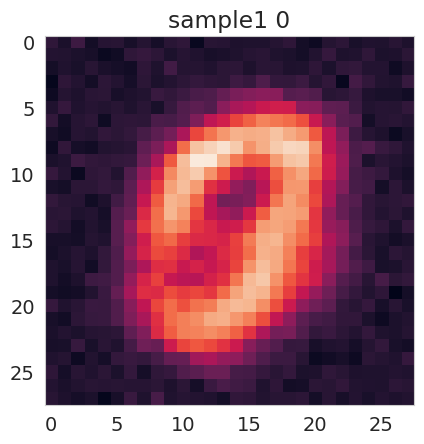

1 train loss: 0.1900
2 train loss: 0.1811


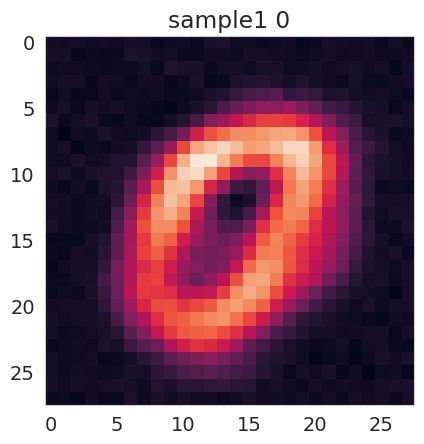

3 train loss: 0.1766
4 train loss: 0.1733


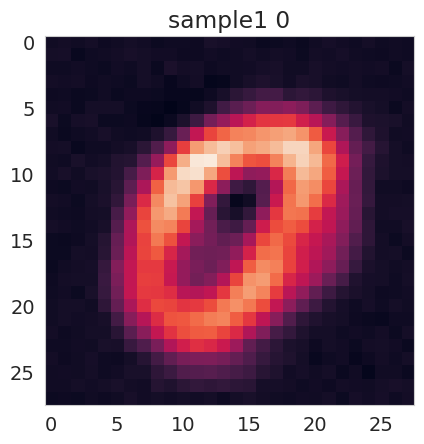

5 train loss: 0.1711
6 train loss: 0.1695


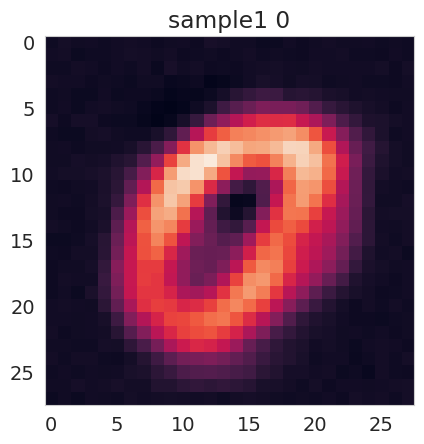

7 train loss: 0.1681
8 train loss: 0.1670


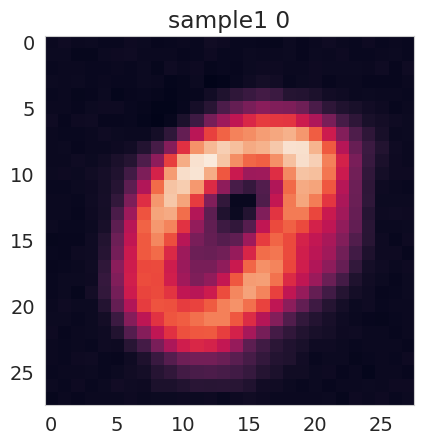

9 train loss: 0.1661
10 train loss: 0.1655


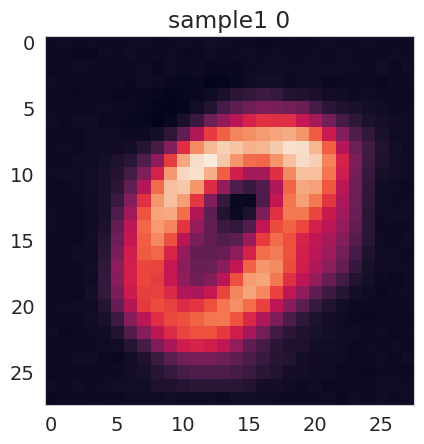

11 train loss: 0.1649
12 train loss: 0.1645


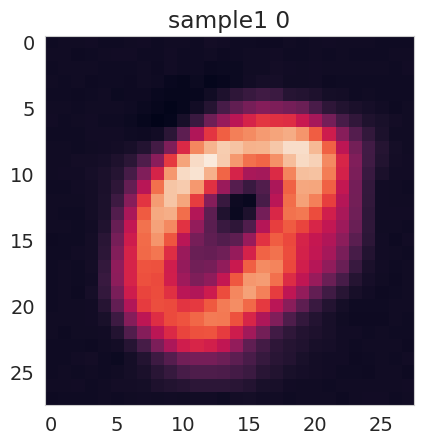

13 train loss: 0.1641
14 train loss: 0.1637


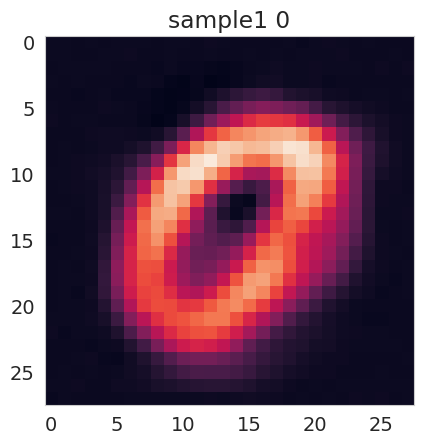

15 train loss: 0.1634
16 train loss: 0.1630


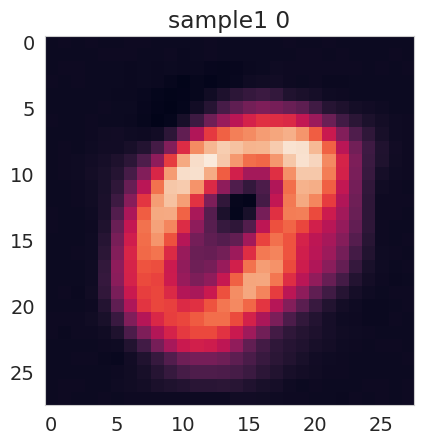

17 train loss: 0.1628
18 train loss: 0.1629


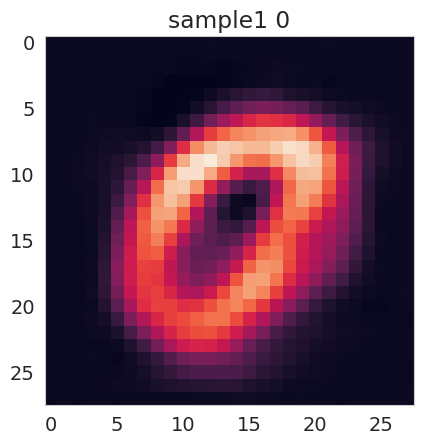

19 train loss: 0.1624


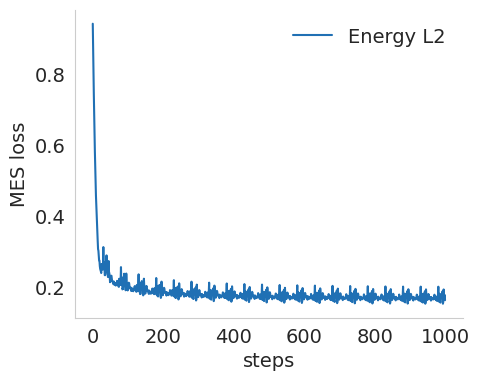

In [21]:
##############################################################
# decode from clamped representations
##############################################################
no_input = torch.zeros((1, IN_dim)).to(device)

MSE_loss = nn.MSELoss()

test_loader2 = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

# linear decoder, but change the following class to other decoder types if necessary
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_dim = hidden_dim

        self.fc1 = nn.Linear(in_dim, out_dim)
        # self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # self.fc3 = nn.Linear(hidden_dim, out_dim)

        # # xavier initialisation
        nn.init.xavier_uniform_(self.fc1.weight)
        # nn.init.xavier_uniform_(self.fc2.weight)
        # nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        # x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        x = self.fc1(x)
        return x

# %%
def plot_projection(rep, label, weights, bias):
    img = (weights @ rep + bias).reshape(28, 28)
    plt.imshow(img)
    plt.title(str(label))
    plt.show()
    return img

def train_linear_proj(layer, model):
    mlp = MLP(hidden_dim[layer], 700, IN_dim).to(device)
    optimiser = optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.0001)

    loss_log = []

    for e in range(20):
        for i, (data, target) in enumerate(test_loader2):
            data, target = data.to(device), target.to(device)
            data = data.view(-1, model.in_dim)

            with torch.no_grad():
                model.eval()

                hidden = model.init_hidden(data.size(0))

                _, h = model.inference(data, hidden, T)

            spks = get_states([h], 1+layer*4, hidden_dim[layer], batch_size, T, batch_size)

            train_data = torch.tensor(spks.mean(axis=1)).to(device)
            # print(train_data.size())

            optimiser.zero_grad()

            out = mlp(train_data)
            loss = MSE_loss(out, data)
            loss_log.append(loss.data.cpu())

            loss.backward()
            optimiser.step()

        print('%i train loss: %.4f' % (e, loss))

        if e %5 == 0:
            plt.imshow(out[target == 0][0].cpu().detach().reshape(28, 28))
            plt.title('sample1 %i' % target[target == 0][0].item())
            plt.show()

            # find the next image with class 0
            # plt.imshow(out[target == 0][1].cpu().detach().reshape(28, 28))
            # plt.title('sample2 %i' % target[target == 0][1].item())
            # plt.show()

    torch.cuda.empty_cache()

    mlp.eval()

    return mlp, [i.cpu() for i in loss_log]

# %%
layer = 1
l2_E_decoder, loss_E = train_linear_proj(layer, model)

decoders = [l2_E_decoder]

# %%
# plot loss curve of training
colors = [(0.1271049596309112, 0.4401845444059977, 0.7074971164936563),
                     (0.9949711649365629, 0.5974778931180315, 0.15949250288350636)]
sns.set_style("whitegrid", {'axes.grid' : False})

fig, ax = plt.subplots(figsize=(5, 4))
plt.rcParams.update({'font.size': 14})

ax.plot(loss_E, label='Energy L%i' % (layer+1), color=colors[0])
ax.legend()
# frame off
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel('MES loss')
ax.set_xlabel('steps')
plt.legend(frameon=False)
# increase font size
plt.show()



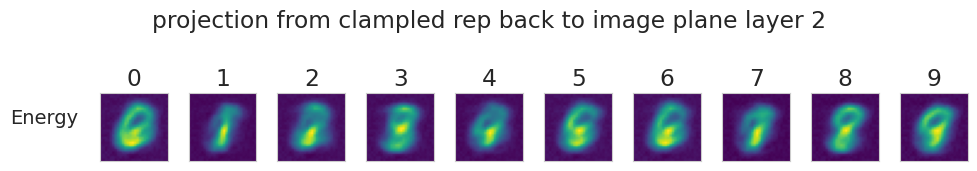

In [22]:

# plot decoding of clamped internal representations 
fig, axes = plt.subplots(1, 10, figsize=(10, 2))

with torch.no_grad():
    for proj_class in range(n_classes):
        img1 = decoders[0](torch.tensor(l2_clamp_E[proj_class].astype('float32')).to(device).view(-1, hidden_dim[layer])).reshape(28, 28).cpu()
        axes[proj_class].imshow(img1, cmap='viridis')
        axes[proj_class].set_title(str(proj_class))
        # axes[0][proj_class].axis('off')
        axes[proj_class].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

fig.suptitle('projection from clampled rep back to image plane layer %i' % (layer+1))
axes[0].set_ylabel('Energy', rotation=0, labelpad=40)

plt.tight_layout()
plt.show()